# NLP Project

The point of this notebook is to show the methodology we used in the main report. Note that due to our research being focused on many runs, we show here a reduced number of runs which does have any statistical meaning but does show our methodology.

# Setup

In [1]:
import pandas as pd
import os
from scripts.utils import *
from sklearn.model_selection import train_test_split
from demo_scripts import demo_preprocessing
from demo_scripts import demo_ga
from demo_scripts import pickle_funcs
from demo_scripts import demo_graphs
from demo_scripts import demo_xgb
from demo_scripts import demo_random_sampler
import numpy as np

# set constant seeds
np.random.seed(0)

c:\Users\tzion\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocessing

For the purposes of demonstration the dataset we will be using is "Wine Quality" available at https://www.kaggle.com/datasets/rajyellow46/wine-quality

The dataset.csv file only has numerical and categorical columns and we arranged the target column to be the last.

In [2]:
df = pd.read_csv('demo_data/dataset.csv')
target_column = df.columns[-1]
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Remove NaN values

The next step in our pipeline is to remove rows with missing values.

In [3]:
df = df.dropna()

## Encode Binary Features

We proceed to encode binary features as an indicator variable named "is_x". In here instead of type being white or red in the first column, we have an indicator column "is_red".

In [4]:
df = demo_preprocessing.binary_encoding(df)
df.head()

,is_red,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## One hot Encoding

In datasets where many categories exist we utilize one-hot encoding, since this dataset doesn't have categorical columns anymore this step does not change the dataset.

In [5]:
df = pd.get_dummies(df)
df = df.replace({True: 1, False: 0})
# put the target column at the end after the one hot encoding
df = df[[column for column in df if column != target_column] + [target_column]]


## Train-Test Split

We then proceed to split the dataset into training set and test set to be used later down the pipeline. We set the test set to be 80% of the samples and we reserve 20% for testing.

In [6]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
x_train = train.drop(columns=[target_column])
y_train = train[target_column]
x_test = test.drop(columns=[target_column])
y_test = test[target_column]
train.to_csv('demo_data/train.csv', index=False)
test.to_csv('demo_data/test.csv', index=False)
print(train.shape, test.shape)

(5170, 13) (1293, 13)


# Experiments

After preprocessing our data use used our genetic algorithms in order to minimize the distance between the PDF of each feature in the train to that of the sample. Note that we exclude the original experiment in which the PDF was calculated by a KDE of varying widths for reasons we explain in the main report.

In [7]:
# We always set the sample size to 50 for the demo
SAMPLE_SIZE = 50

## Baselines

Here we show all the baselines used in our report.

### Random Sampler

We sample 50 samples randomly and train the XGB model and test it.

In [8]:
x_sample_random, y_sample_random = demo_random_sampler.sample_data(x_train.to_numpy(), y_train.to_numpy(), SAMPLE_SIZE)
sample_random_df = pd.DataFrame(x_sample_random, columns=x_train.columns)
sample_random_df[target_column] = y_sample_random
mse_random = demo_xgb.xgb_results_regression(x_sample_random, x_test, y_sample_random, y_test)
print(f"Random sampling MSE: {mse_random}")

Random sampling MSE: 0.8476701898066666


### All Training Data

Here we use all the training data and feed it to the XGB model.

In [9]:
mse_all = demo_xgb.xgb_results_regression(x_train, x_test, y_train, y_test)
print(f"All data MSE: {mse_all}")

All data MSE: 0.41983065828638727


### Constant Predictions

Here we included the MSE of models that always output the mean or median.

In [10]:
mean = y_train.mean()
median = y_train.median()

# calculate the mse for always predicting the mean
mse_mean = ((y_test - mean) ** 2).mean()
print(f"Mean MSE: {mse_mean}")

# calculate the mse for always predicting the median
mse_median = ((y_test - median) ** 2).mean()
print(f"Median MSE: {mse_median}")

Mean MSE: 0.7925015493930947
Median MSE: 0.8221191028615623


## First

In the first experiment the objective function was to minimize the sum of all the distances between each 2 pairs of PDFs for the features only. Below is an example run of the genetic algorithm using the Wasserstein distance.

In [11]:
#x_sample, y_sample, history = demo_ga.first_method(train=train, sample_size=SAMPLE_SIZE)

# save as pickle
#pickle_funcs.save_sample(x_sample, y_sample, history, 1)

# load pickle
x_sample, y_sample, history = pickle_funcs.load_sample(1)
sample_df = pd.DataFrame(x_sample, columns=x_train.columns)
sample_df[target_column] = y_sample

Next we will show that the objective function is actually being minimized by plotting it over generations.

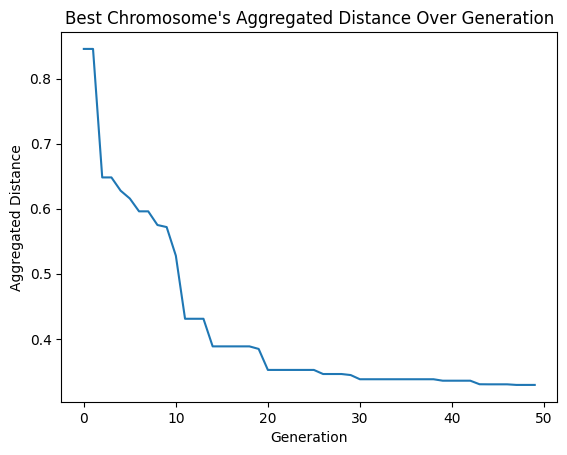

In [12]:
demo_graphs.plot_objective_over_generation(history)

We can visualize the PDF of one of the features to see that our algorithm does work.

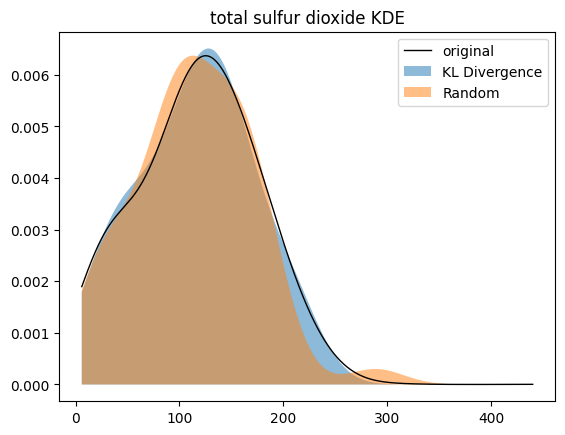

In [13]:
demo_graphs.plot_head_to_head_kde(train, sample_df, sample_random_df, 'total sulfur dioxide', "KL Divergence", "Random")

Here we showcase the results of this specific run, note that after a lot of runs this did not improve things for most cases when accounting for different datasets, different sample sizes and multiple runs.

In [14]:
mse_ga = demo_xgb.xgb_results_regression(x_sample, x_test, y_sample, y_test)
print(f"GA sampling MSE: {mse_ga}")

GA sampling MSE: 0.7957995532613598


## Second

Following the first experiment we wanted to see if adding the distance between the PDF of the label to the sum of distances will help.

We first start by showing that the prior objective function indeed doesn't account for the target and can in-fact hurt it by trying to optimize the rest of the distances.

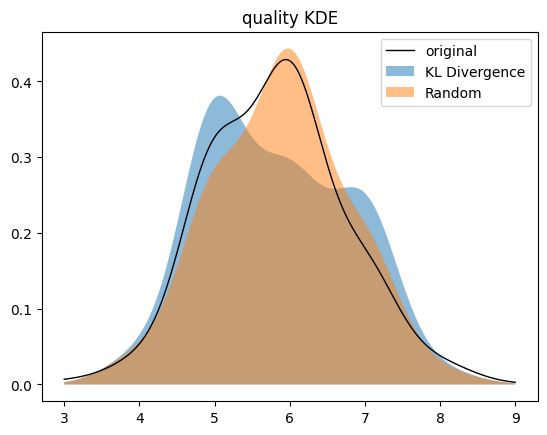

In [15]:
demo_graphs.plot_head_to_head_kde(train, sample_df, sample_random_df, 'quality', "KL Divergence", "Random")

We first run the genetic algorithm and get the samples.

In [16]:
#x_sample, y_sample, history = demo_ga.second_method(train=train, sample_size=SAMPLE_SIZE)

# save as pickle
#pickle_funcs.save_sample(x_sample, y_sample, history, 2)

# load pickle
x_sample, y_sample, history = pickle_funcs.load_sample(2)
sample_df = pd.DataFrame(x_sample, columns=x_train.columns)
sample_df[target_column] = y_sample

And indeed now the GA accounts for the target column.

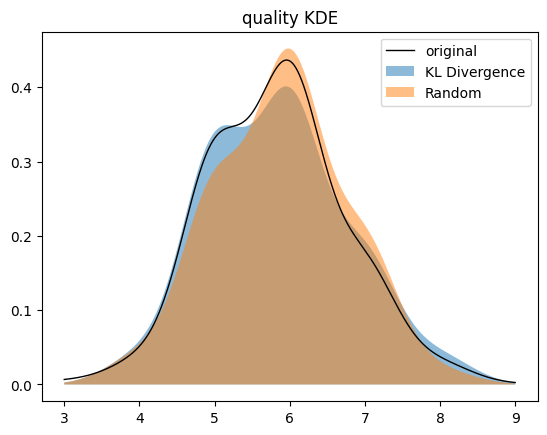

In [17]:
demo_graphs.plot_head_to_head_kde(train, sample_df, sample_random_df, 'quality', "KL Divergence", "Random")

We showcase here the XGB results, but after extensive testing this also did not improve things.

In [18]:
mse_ga = demo_xgb.xgb_results_regression(x_sample, x_test, y_sample, y_test)
print(f"GA sampling MSE: {mse_ga}")

GA sampling MSE: 0.8391075139134172


## Third

Since the above two approaches didn't work we decided to try reducing the number of used features in the optimization to account only for those having a high correlation with the target. Our reasoning is that perhaps some features are redundant and due to the algorithm trying to optimize their distances it can "hurt" the useful ones.

First we select the features that correlate the most with the target.

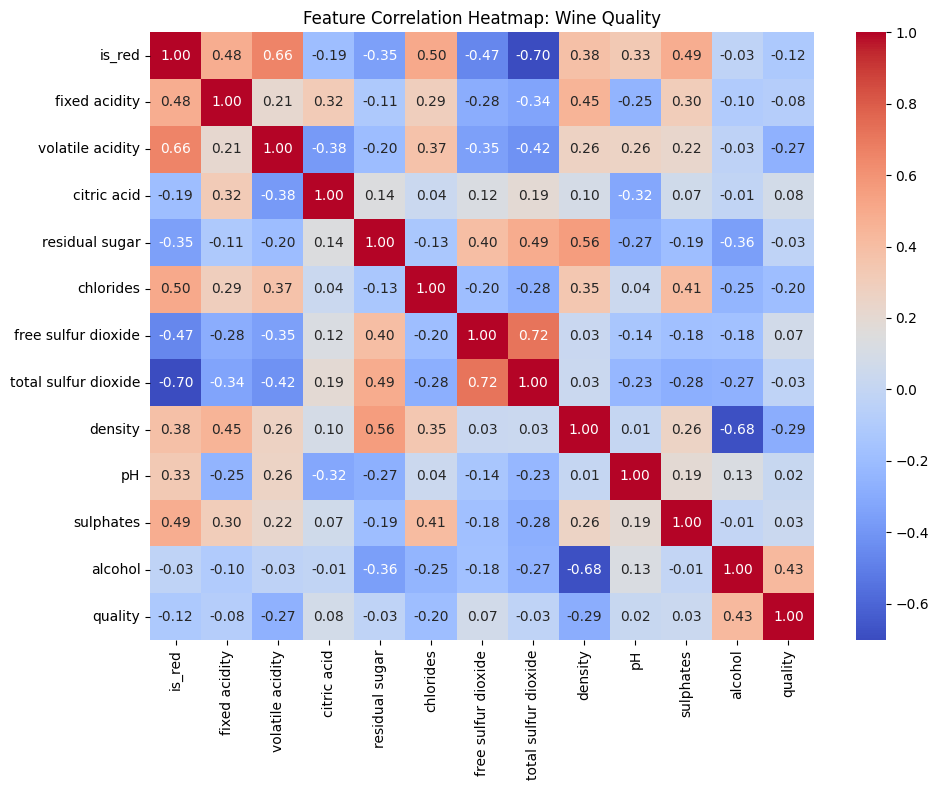

In [19]:
demo_graphs.plot_correlation_heatmap("Wine Quality", train)

According to the above graph the features that correlate the most (in magnitude) with the label were: 'volatile acidity' 'chlorides' 'density' and 'alcohol', we then added the target to the optimization as well.

In [20]:
#x_sample, y_sample, history = demo_ga.third_method(train=train, sample_size=SAMPLE_SIZE)

# save as pickle
#pickle_funcs.save_sample(x_sample, y_sample, history, 3)

# load pickle
x_sample, y_sample, history = pickle_funcs.load_sample(3)
sample_df = pd.DataFrame(x_sample, columns=x_train.columns)
sample_df[target_column] = y_sample

TODO TODO TODO TODO

## Fourth

We thought that while using pearson might capture some correlation it only does so for features that are somewhat linearly correlated with the feature and might not catch complex behavior that still affect the target. So we decided to aggregate and use the SHAP values in order to extract feature importance.

We first calculate the mean-absolute-SHAP-value per feature to get the feature importance. For this particular task the directionality doesn't matter and we are only interested in the magnitude of the impact. 

Notice how using the SHAP values instead of the pearson correlation we found that free 'sulfur dioxite' is affecting the model more than 'density' which might mean it is a more important feature to optimize over. Note that density correlates decently with alcohol which in turn correlates highly with the quality, so it could be the case that the feature 'density' is redundant to the model.

In [21]:
demo_xgb.get_shap_values_after_xgb(x_train, y_train)

,Feature,SHAP Importance
11,alcohol,0.273205
2,volatile acidity,0.161490
6,free sulfur dioxide,0.123422
7,total sulfur dioxide,0.101765
4,residual sugar,0.093068
10,sulphates,0.089150
8,density,0.080774
5,chlorides,0.072903
9,pH,0.066626
3,citric acid,0.060227


In this example we will select the 4 features with the highest importace score and the label as well.

In [22]:
#x_sample, y_sample, history = demo_ga.fourth_method(train=train, sample_size=SAMPLE_SIZE)

# save as pickle
#pickle_funcs.save_sample(x_sample, y_sample, history, 4)

# load pickle
x_sample, y_sample, history = pickle_funcs.load_sample(4)
sample_df = pd.DataFrame(x_sample, columns=x_train.columns)
sample_df[target_column] = y_sample